## IBM Employee Attrition Prediction

**Project Overview**

Employee turnover (also known as "employee churn") is a costly issue for companies. The same thing happened to the IBM company. The amount of costs incurred by IBM in employee turnover is very large. This is due to the large amount of time spent on hiring, sign-in bonuses, and lost productivity over the course of several months while the new employee gets used to the new role.

> *Managers tend to blame their turnover problems on everything under the sun, while ignoring the crux of the matter: people don't leave jobs; they leave managers. -- Travis BradBerry*

**Problem Statement**

Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as possibly planning new hiring in advance. I will be usign a step-by-step systematic approach using a method that could be used for a variety of ML problems. This project would fall under what is commonly known as "HR Anlytics" or "People Analytics".

HR analytics is the process of collecting and analyzing Human Resource (HR) data in order to improve an organization’s workforce performance. The process can also be referred to as talent analytics, people analytics, or even workforce analytics. This method of data analysis takes data that is routinely collected by HR and correlates it to HR and organizational objectives. Doing so provides measured evidence of how HR initiatives are contributing to the organization’s goals and strategies.

In this study, we will attempt to solve the following problem statement is:

* What is the likelihood of an active employee leaving the company?
* What are the key indicators of an employee leaving the company?
* What policies or strategies can be adopted based on the results to improve employee retention?


So lets start with our analysis!!!

### Mount Google Drive

In [557]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [558]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

### Read Data

**Dataset Analysis**

In this case study, a HR dataset was sourced from [IBM HR Analytics Employee Attrition & Performance](https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/) which contains employee data for 1,470 employees with various information about the employees. I will use this dataset to predict when employees are going to quit by understanding the main drivers of employee churn.

As stated on the [IBM website](https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/) "This is a fictional data set created by IBM data scientists". Its main purpose was to demonstrate the IBM Watson Analytics tool for employee attrition.

Let's import the dataset!

In [559]:
BASEPATH = '/content/drive/MyDrive/Dibimbing/Kaggle/IBM_Employee_Attrition'

In [560]:
filepath = os.path.join(BASEPATH, 'Data', 'WA_Fn-UseC_-HR-Employee-Attrition.csv')
df = pd.read_csv(filepath)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [561]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [562]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [563]:
df.shape

(1470, 35)

In [564]:
df['Attrition'].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

**Summary of our Data:**

* **Dataset Structure:** 1470 observations (rows), 35 features (variables)
* **Missing Data:** Luckily for us, there is no missing data! this will make it easier to work with the dataset.
* **Data Type:** We only have two datatypes in this dataset: 9 categoricals and 26 numericals
* **Label:** Attrition is the label in our dataset and we would like to find out why employees are leaving the organization
* **Imbalanced dataset:** 1233 (84% of cases) employees did not leave the organization while 237 (16% of cases) did leave the organization making our dataset to be considered imbalanced since more people stay in the organization than they actually leave.

### Split Data

Let's create a validation set! 

The validation set allows us to explore and evaluate many models/hyperparameter settings. When we make a decision about which model to use, the validation set allows us to validate whether the decision is really a good one, without conforming to the test set. Similarly with EDA, if we make decisions about our model (which features to choose, etc.), the validation set will help us validate whether our EDA decisions are good.

Therefore, I will do EDA only on the training set and use the validation set to evaluate the quality of every decision I make on the training set.

In [565]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=41)

print(f"Amount of training data: {train_df.shape[0]}")
print(f"Amount of testing data: {test_df.shape[0]}")

Amount of training data: 1176
Amount of testing data: 294


### Data Exploration

One of the first things in my journey of Data Science, was to always know the story behind the data. What's the point of implementing predictive algorithms if you don't know what your data is about? My philosophy is to "drill down" the data until I find interesting insights that will give me a better understanding of my data.

#### Numerical Features

In [566]:
numerical_type = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_df = train_df.select_dtypes(include=numerical_type)
num_df.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
272,28,1158,9,3,1,377,4,94,3,1,4,2070,2613,1,23,4,4,80,1,5,3,2,5,2,0,4
909,19,265,25,3,1,1269,2,57,4,1,4,2994,21221,1,12,3,4,80,0,1,2,3,1,0,0,1
975,55,267,13,4,1,1372,1,85,4,4,3,13695,9277,6,17,3,3,80,0,24,2,2,19,7,3,8
1383,36,1351,9,4,1,1949,1,66,4,1,2,2810,9238,1,22,4,2,80,0,5,3,3,5,4,0,2
191,27,894,9,3,1,260,4,99,3,1,2,2279,11781,1,16,3,4,80,0,7,2,2,7,7,0,3


In [567]:
num_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.00000,1176.000000,1176.000000,1176.000000
mean,36.464286,791.761905,9.108844,2.897959,1.0,1025.671769,2.715986,65.627551,2.727891,2.039966,2.738946,6414.920918,14438.312925,2.647959,15.235544,3.160714,2.716837,80.0,0.775510,11.008503,2.783163,2.761905,6.92602,4.198129,2.092687,4.027211
std,9.031694,400.486059,7.944599,1.024697,0.0,610.567646,1.095888,20.332279,0.706761,1.095104,1.101974,4639.278876,7136.866260,2.489169,3.674843,0.367423,1.077707,0.0,0.848897,7.633962,1.297364,0.713000,6.05356,3.619902,3.117131,3.573559
min,18.000000,103.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000
25%,30.000000,460.500000,2.000000,2.000000,1.0,470.500000,2.000000,48.000000,2.000000,1.000000,2.000000,2902.250000,8057.500000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.00000,2.000000,0.000000,2.000000
50%,35.000000,783.000000,7.000000,3.000000,1.0,1031.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4850.500000,14379.500000,1.000000,14.000000,3.000000,3.000000,80.0,1.000000,9.000000,3.000000,3.000000,5.00000,3.000000,1.000000,3.000000
75%,42.000000,1144.000000,13.000000,4.000000,1.0,1578.500000,4.000000,83.000000,3.000000,3.000000,4.000000,8281.250000,20741.750000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.00000,7.000000,2.000000,7.000000
max,60.000000,1498.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19973.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.00000,18.000000,15.000000,17.000000


The features are not on the same scale. For example `PercentSalaryHike` has a mean of 15.24 while `MonthlyIncome` has a mean value of 6536.40. Features should be on the same scale for algorithms such as logistic regression (gradient descent) to converge smoothly.

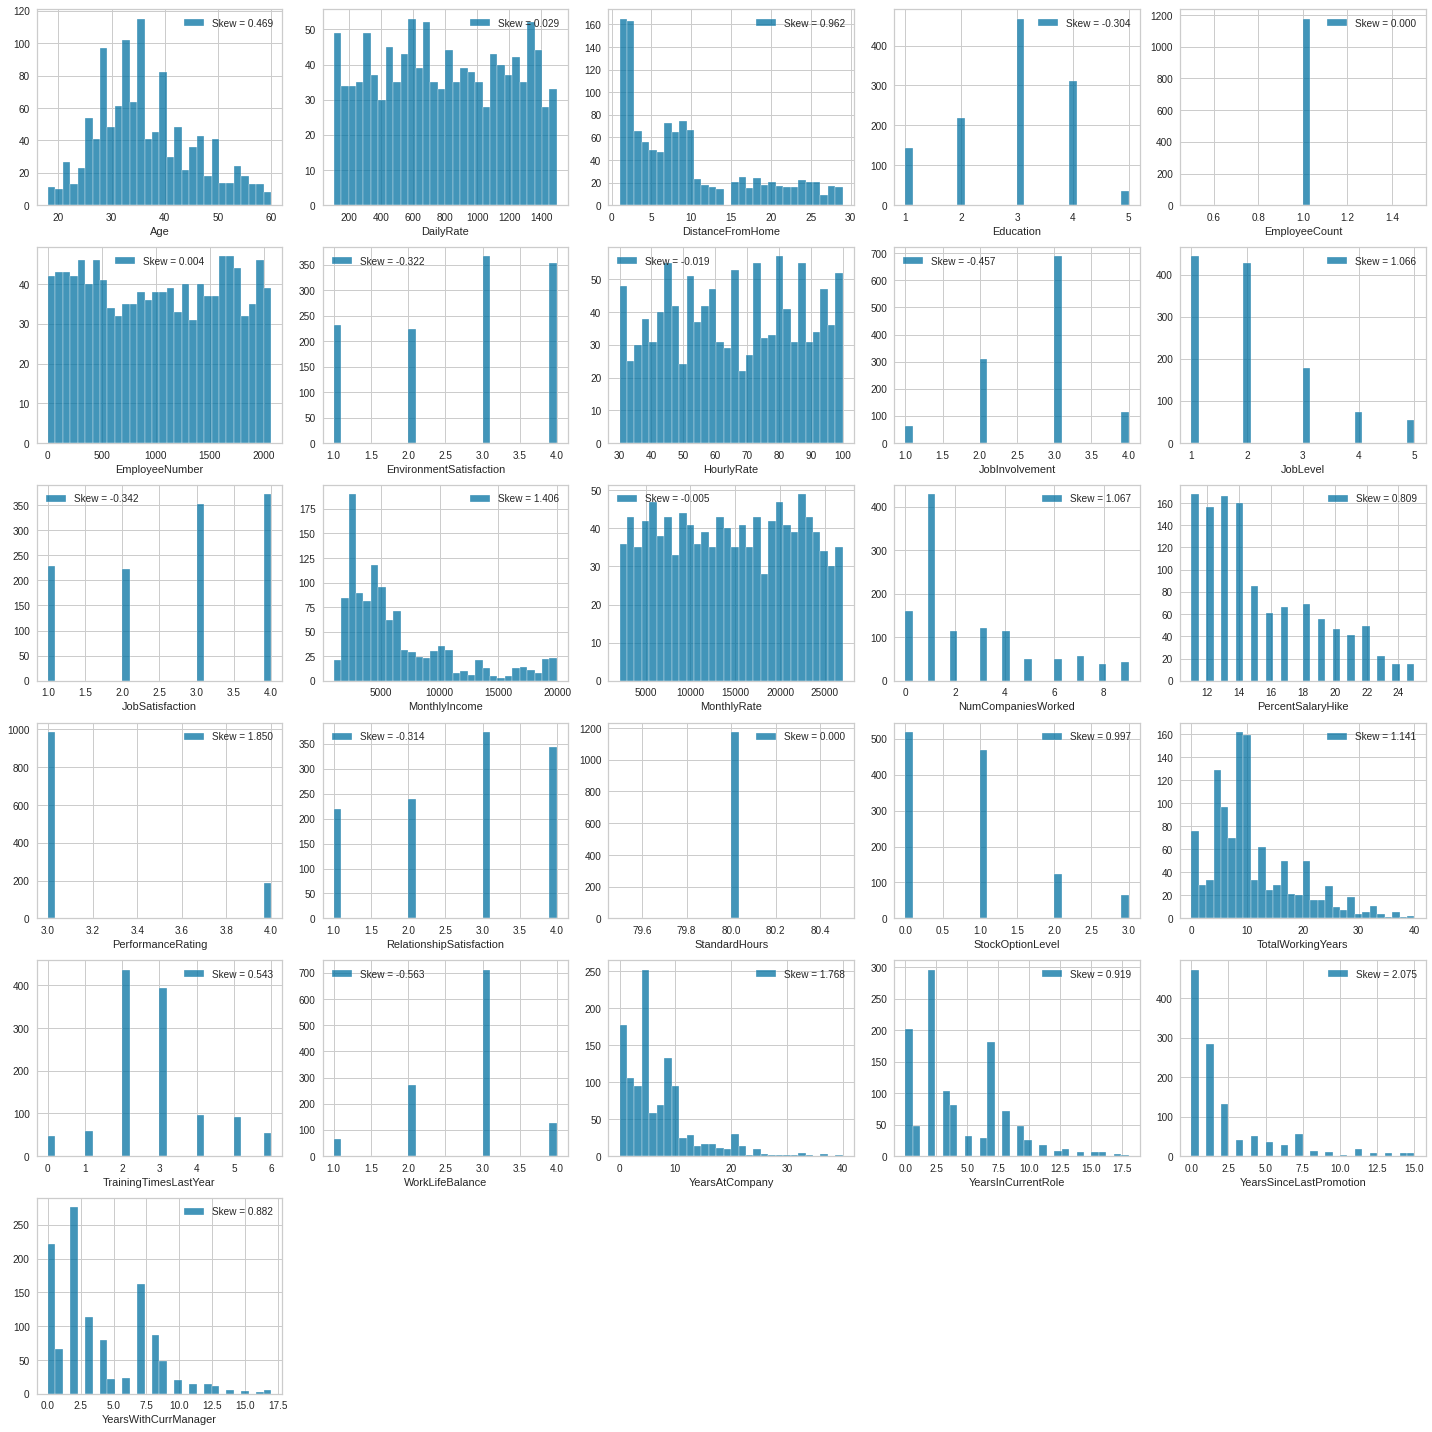

In [568]:
num_features = num_df.columns
f, axes = plt.subplots(6, 5, figsize=(20, 20), tight_layout=True)
f.delaxes(ax = axes[5,1])
f.delaxes(ax = axes[5,2])
f.delaxes(ax = axes[5,3])
f.delaxes(ax = axes[5,4])
for feat, ax in zip(num_features, axes.flatten()):
    skew = num_df[feat].skew()
    sns.histplot(num_df, x=feat, label='Skew = %.3f' %(skew), bins=30, color='b', edgecolor='w', ax=ax)
    ax.set_ylabel('')
    ax.legend(loc='best')
plt.show()

A few observations can be made based on the information and histograms for numerical features:

* None of the features is normally distributed; indeed several distributions are right-skewed (e.g. MonthlyIncome, DistanceFromHome, YearsAtCompany, YearSinceLastPromotion). Data transformation methods may be required to approach a normal distribution prior to fitting a model to the data.

* Age distribution is a slightly right-skewed normal distribution with the bulk of the staff between 25 and 45 years old.

* EmployeeCount and StandardHours are constant values for all employees. They're likely to be redundant features.

* Employee Number is likely to be a unique identifier for employees.

#### Categorical Features

In [569]:
categorical_type = ['object']
cat_df = train_df.select_dtypes(include=categorical_type)
cat_df.head()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
272,No,Travel_Rarely,Research & Development,Medical,Male,Research Scientist,Married,Y,No
909,No,Travel_Rarely,Research & Development,Life Sciences,Female,Research Scientist,Single,Y,Yes
975,Yes,Travel_Rarely,Sales,Marketing,Male,Sales Executive,Single,Y,Yes
1383,No,Non-Travel,Research & Development,Life Sciences,Male,Laboratory Technician,Married,Y,No
191,No,Travel_Rarely,Research & Development,Medical,Female,Research Scientist,Single,Y,No


In [570]:
cat_df.describe()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1176,1176,1176,1176,1176,1176,1176,1176,1176
unique,2,3,3,6,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,979,850,767,496,711,265,530,1176,850


No columns that have high uniqueness. `Over18` is constant values for all employees.

#### Target Analysis

In [571]:
train_df['Attrition'].value_counts()

No     979
Yes    197
Name: Attrition, dtype: int64

In [572]:
print("Percentage of Current Employees is {:.1f}% and of Ex-employees is: {:.1f}%".format(
    train_df[train_df['Attrition'] == 'No'].shape[0] / train_df.shape[0]*100,
    train_df[train_df['Attrition'] == 'Yes'].shape[0] / train_df.shape[0]*100))

Percentage of Current Employees is 83.2% and of Ex-employees is: 16.8%


In [573]:
target_att = train_df.groupby(['Attrition'])['Attrition'].agg(['count']).reset_index().sort_values('count', ascending=False)

fig = px.bar(
    target_att,
    x="count", 
    y="Attrition",  
    template = 'plotly_white',
    title='Label Distribution',
    orientation='h'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

The dataset is pretty unbalanced. 83.2% of employees did not quit the organization while 16.8% did leave the organization. Machine learning algorithms typically work best when the number of instances of each classes are roughly equal. Knowing that we are dealing with an imbalanced dataset We will have to address this target feature imbalance prior to implementing our Machine Learning algorithms.

#### An In-Depth Look into Attrition

We will go as deep as we can into employees that quit to have a better understanding what were some of the reasons that employees decided to leave the organization.

##### How does age affect attrition?

Age distributions for Active Employee and Ex-employees

In [574]:
age = train_df.groupby(['Attrition']).agg(mean_age=('Age', 'mean')).reset_index()
age

,Attrition,mean_age
0,No,37.006129
1,Yes,33.771574


Average age of ex-employees is 34 years old, while 37 is the average age for current employees.

In [575]:
age_att = train_df.groupby(['Age','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
px.line(age_att, x='Age', y='count', color='Attrition', title='Age Distribution by Attrition Status')

The attrition is maximum between the age groups 28-33. The attrition rate keeps on falling with increasing age, as people look after stability in their jobs at these point of times. Also at a very younger age, i.e. from 18-23, the chances of an employee leaving the organization is far more- since they are exploring at that point of time. It reaches a break even point at the age of 20

##### What is the employee resignation rate of each department?

In [576]:
department_att = train_df.groupby(['Department','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
department_att['prop'] = department_att.groupby(['Department'])['count'].transform(lambda x: round((x/sum(x)*100),2).astype(int))

fig = px.bar(
    department_att[department_att['Attrition'] == 'Yes'],
    x="Department", 
    y="prop",
    color="Attrition",
    template = 'plotly_white',
    title='Percentage Ex-Employee off All Department (%)'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

The data features employee data from three departments: Research & Development, Sales, and Human Resources. Research & Development is the department with the lowest attrition rate

##### Is monthly income an important factor in employee attrition?

In [577]:
px.box(train_df, x='Attrition', y='MonthlyIncome', color='Gender', title='Monthly Income Distribution by Gender and Attrition Status')

In [578]:
income_att = train_df
income_att['MonthlyIncome']=round(income_att['MonthlyIncome'],-3)
income_att = income_att.groupby(['MonthlyIncome','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
px.line(income_att, x='MonthlyIncome', y='count', color='Attrition', title='Monthly Income Distribution by Attrition Status')

The level of attrition does occur in low-income employees. In women, it occurs in employees with a median income of 3492 compared with 5175 - for active employees. And for men, it happened for employees with a median income of 3441 versus 4964 - for active employees.

And the highest level of attrition is at a very low level of income - less than 5 thousand per month. It declined further - but there was a small spike seen in incomes of around 10,000 - suggesting middle-class living. They tend to move on to a better standard of living, and therefore move to a different job.
When the monthly income is good enough, it is likely that a person will be more loyal to the organization, as shown in the flat line.

##### Do performance ratings have an impact on earning more? Is the difference significant by Attrition status?

In [579]:
px.box(train_df, x='PerformanceRating', y='MonthlyIncome', color='Attrition', title='Monthly Income by Performance Rating and Attrition Status')

In [580]:
perform_att = train_df[train_df['Attrition']=="Yes"].groupby(['PerformanceRating']).agg(count=('EmployeeNumber', 'count')).reset_index()

fig = px.bar(
    perform_att,
    x="PerformanceRating", 
    y="count",
    template = 'plotly_white',
    title='Ex-Employee Performance Rating'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

For active employees, there is no significant difference in terms of income based on employee performance.
But lower performing employees leave the company more

##### Does salary hike percentage impact the Attrition?

In [581]:
hike_att = train_df.groupby(['Attrition','PercentSalaryHike']).agg(count=('EmployeeNumber', 'count')).reset_index()
px.line(hike_att, x="PercentSalaryHike", y="count", color='Attrition')

In [582]:
income_hike_att = train_df.groupby(['Attrition','PercentSalaryHike','MonthlyIncome']).agg(count=('EmployeeNumber', 'count')).reset_index()
px.scatter(income_hike_att, x='PercentSalaryHike', y='MonthlyIncome', facet_col='Attrition', color='Attrition', size='count', trendline="ols", title='Percent Salary Hike Impact on Attrition')

The higher the salary, the smaller the percentage of the salary hike. But in general, many employees actually have low salaries and the percentage of salary increases is also low.

Higher hikes motivate people to stay in the organization. Hence we see the chances of an employee leaving the organization where the hike is lower, is much more than a company that gives a good hike.

##### Do stock options increase employee loyalty?

In [583]:
stock_att = train_df.groupby(['StockOptionLevel','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
stock_att['StockOptionLevel'] = stock_att['StockOptionLevel'].astype('category')

fig = px.bar(
    stock_att,
    x="StockOptionLevel", 
    y="count",
    color="Attrition",
    template = 'plotly_white',
    barmode = 'group',
    title='Attrition Status by Stock Options'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

In [584]:
stock_att['prop'] = stock_att.groupby(['StockOptionLevel'])['count'].transform(lambda x: round((x/sum(x)*100),2).astype(int))

fig = px.bar(
    stock_att[stock_att['Attrition'] == 'Yes'],
    x="StockOptionLevel", 
    y="prop",
    color="Attrition",
    template = 'plotly_white',
    title='Percentage Ex-Employee Stock Options of All Employee (%)'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

The tendency of employees to leave the organization is much more when the stock availing options are limited. Since the stocks constitute to a huge amount of money while staying for a few years, people do not want to lose that opportunity. People with very limited/no stcok options have a freedom to leave the organization at will.

##### How does employee satisfaction impact the attrition?

In [585]:
env_att = train_df.groupby(['EnvironmentSatisfaction','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
env_att['EnvironmentSatisfaction'] = env_att['EnvironmentSatisfaction'].astype('category')

fig = px.bar(
    env_att,
    x="EnvironmentSatisfaction", 
    y="count",
    color="Attrition",
    template = 'plotly_white',
    barmode = 'group',
    title='Environment Satisfaction by Attrition Status'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

In [586]:
job_att = train_df.groupby(['JobSatisfaction','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
job_att['JobSatisfaction'] = job_att['JobSatisfaction'].astype('category')

fig = px.bar(
    job_att,
    x="JobSatisfaction", 
    y="count",
    color="Attrition",
    template = 'plotly_white',
    barmode = 'group',
    title='Job Satisfaction by Attrition Status'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

In [587]:
relationship_att = train_df.groupby(['RelationshipSatisfaction','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
relationship_att['RelationshipSatisfaction'] = relationship_att['RelationshipSatisfaction'].astype('category')

fig = px.bar(
    relationship_att,
    x="RelationshipSatisfaction", 
    y="count",
    color="Attrition",
    template = 'plotly_white',
    barmode = 'group',
    title='Relationship Satisfaction by Attrition Status'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

Environment, Job and Relationship Satisfaction, was captured as: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'.

In environmental satisfaction and job satisfaction there is the same pattern, at levels 1 to 2 there is a decrease in the tendency of employees to leave the company. This is an indication that employees with satisfaction at level 2 have expectations of the company, that their work and work environment can be better. However, as we move from 2 to 3, people tend to change jobs for better opportunities and experiences. Attrition levels are almost stagnant for higher satisfaction levels.

Meanwhile, if we look at the proportion between employees who leave and those who do not, we can see that the proportion of employees who leave decreases as the Environmental Satisfaction score increases. And the Proportion of Exiting Employees decreased along with the increase in Job Satisfaction scores.

##### Does frequent overtime increase employee attrition?

All employees have a standard 80-hour work commitment. Some employees have overtime commitments.

In [588]:
overtime_att = train_df.groupby(['OverTime','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()

fig = px.bar(
    overtime_att,
    x="Attrition", 
    y="count",
    color="OverTime",
    template = 'plotly_white',
    barmode = 'group',
    title='Overtime by Attrition Status'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

In [589]:
overtime_att_prop = train_df[train_df['Attrition'] == 'Yes'].groupby(['OverTime']).agg(count=('EmployeeNumber', 'count')).reset_index()
overtime_att_prop['prop'] = round(overtime_att_prop['count'] / overtime_att_prop['count'].sum() * 100,2)

fig = px.bar(
    overtime_att_prop,
    x="OverTime", 
    y="prop",
    color='OverTime',
    template = 'plotly_white',
    title='Ex-Employee OverTime Percentage'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

The data clearly show that there is significant larger portion of employees with OverTime that have left the company. Over 55% of workers who left the organization worked overtime! Will this be a reason why employees are leaving?

##### How does work life balance impact the attrition rates?

In [590]:
wlb_att = train_df.groupby(['WorkLifeBalance','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
wlb_att['WorkLifeBalance'] = wlb_att['WorkLifeBalance'].astype('category')

fig = px.bar(
    wlb_att,
    x="WorkLifeBalance", 
    y="count",
    color="Attrition",
    template = 'plotly_white',
    barmode = 'group',
    title='Work Life Balance by Attrition Status'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

A feature related to "Work-Life Balance" was captured as: 1 'Bad' 2 'Good' 3 'Better' 4 'Best'. People with poor levels of Work life balance have adjusted themselves to their jobs, but as seen for the above parameters with a better work life score, people are more accustomed to the better life and want to go for an attrition more. But this trend perishes when the work life balance is really good, and people are satisfied with the work they are doing.

##### Does frequent business trips have an impact on employee attrision?

In [591]:
travel_att = train_df.groupby(['BusinessTravel','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
travel_att['BusinessTravel'] = travel_att['BusinessTravel'].astype('category')

fig = px.bar(
    travel_att,
    x="BusinessTravel", 
    y="count",
    color="Attrition",
    template = 'plotly_white',
    barmode = 'group',
    title='Attrition Status by Business Travel'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

In [592]:
travel_att['prop'] = travel_att.groupby(['BusinessTravel'])['count'].transform(lambda x: round((x/sum(x)*100),2).astype(int))

fig = px.bar(
    travel_att[stock_att['Attrition'] == 'Yes'],
    x="BusinessTravel", 
    y="prop",
    color="Attrition",
    template = 'plotly_white',
    title='Percentage Ex-Employee Business Travel of All Employee (%)'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

A preliminary look at the relationship between Business Travel frequency and Attrition Status shows that there is a largest normalized proportion of Ex-employees that travel "frequently". It could be that people who travel a lot have more opportunities to meet new people, make connections, so they are interested in moving to a new place of work. Or presume that travelling means staying somewhere else overnight, or for a longer period of time, which is why we may connect this to work-life balance issues. 

Travel metrics associated with Business Travel status were not disclosed (i.e. how many hours of Travel is considered "Frequent").

##### Does distance from home affect the level of employee attrition?

In [593]:
distance_att = train_df.groupby(['DistanceFromHome','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
px.line(distance_att, x='DistanceFromHome', y='count', color='Attrition', title='Distance From Home by Attrition Status')

Distance from home for employees to get to work varies from 1 to 29 miles. There is no discernable strong correlation between Distance from Home and Attrition Status

##### How does work experience affect attrition?

There is a feature for the number of companies the employee has worked at.
0 likely indicates that according to records, the employee has only worked at this company

In [594]:
px.histogram(train_df, x="NumCompaniesWorked", color='Attrition', barmode='overlay', title='Work Experience Level by Attrition status')

Clearly, employees who started their career with other company- or have switched to the company in the initial years of their career, have a higher chances of leaving the organization to a different company. People who have gained much experience- working in multiple companies tend to stay in the company they join

##### Waiting time for promotion based on length of work, does it affect employee turnover?

In [595]:
long_att = train_df.groupby(['Attrition','JobLevel','YearsAtCompany','YearsSinceLastPromotion']).agg(count=('EmployeeNumber', 'count')).reset_index()
px.scatter(long_att, x='YearsAtCompany', y='YearsSinceLastPromotion', color='JobLevel', facet_col='Attrition', size='count', trendline="ols", title='Waiting for Promotion based on Length of Work')

The graph above shows how long worked at the company in terms of Years since last promotion, broken down by Employment and Attrition Rate. This is an interesting problem, because the high correlation between these two variables (the longer you work with the company, the less likely you are to be promoted) can mean that people are not really growing within the company. Especially if you look at data from employees who leave the company, attrition most often occurs in employees with less than 5 years of service, this proves that this company has a high turnover rate.

Interestingly, the data for the longest promoted employee has a JobLevel 1, it is very possible that the person is not performing well, so he decides to leave the company.

##### How does Work duration in current role impact Attrition?

In [596]:
current_att = train_df.groupby(['YearsInCurrentRole','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
px.line(current_att, x='YearsInCurrentRole', y='count', color='Attrition', title='Attrition Status due to Stay in Current Role')

We have seen people are more prone to leave the organization in the starting years on their role. When people are in the same role for a long period of time, they tend to stay longer for moving in an upward role.

##### Are managers the reason employees leave the company?

In [597]:
manager_att = train_df.groupby(['YearsWithCurrManager','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
px.line(manager_att, x='YearsWithCurrManager', y='count', color='Attrition', title='Attrition Status due to Same Manager')

We notice 3 major spikes in the attrition rate, when we are analyzing the relationship of an employee with their manager. At the very start, where the time spent with the manager is relatively less- people tend to leave their jobs- considering their relationship with their previous managers. At an average span of 2 years, when employees feel they need an improvement, they also tend to go for a change. When the time spent with the manager is slightly higher (about 7 years)- people tend to find their career progression stagnant, and tend to go for a change. But when the relative time spend with a manager is very high- people are satisfied with their work. Hence the chances of an employee resigning then is significantly low.

##### Does low job involvement cause a desire to leave the company?

In [598]:
jobinvolve_att = train_df.groupby(['JobInvolvement','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
jobinvolve_att['prop'] = jobinvolve_att.groupby(['JobInvolvement'])['count'].transform(lambda x: round((x/sum(x)*100),2).astype(int))

fig = px.bar(
    jobinvolve_att[jobinvolve_att['Attrition'] == 'Yes'],
    x="JobInvolvement", 
    y="prop",
    color="Attrition",
    template = 'plotly_white',
    title='Percentage Ex-Employee Job Involvement of All Employee (%)'
)
fig.update_layout(yaxis_categoryorder = 'total ascending')

A ranking is associated to the employee's Job Involvement :1 'Low' 2 'Medium' 3 'High' 4 'Very High'. The plot below indicates a negative correlation with the Job Involvement of an employee and the Attrition Status. In other words, employees with higher Job Involvement are less likely to leave.

##### Does long absence from training affect employee attrition?

The data indicates that employees may have access to some Training. A feature indicates how many years it's been since the employee attended such training.

In [599]:
training_att = train_df.groupby(['TrainingTimesLastYear','Attrition']).agg(count=('EmployeeNumber', 'count')).reset_index()
px.bar(training_att, x='TrainingTimesLastYear', y='count', color='Attrition')

It can be seen that many employees did not receive training after the last 2 years and 3 years of receiving training. And the company began to intensively provide retraining after the 4th year after the last training.

#### Outlier Analysis

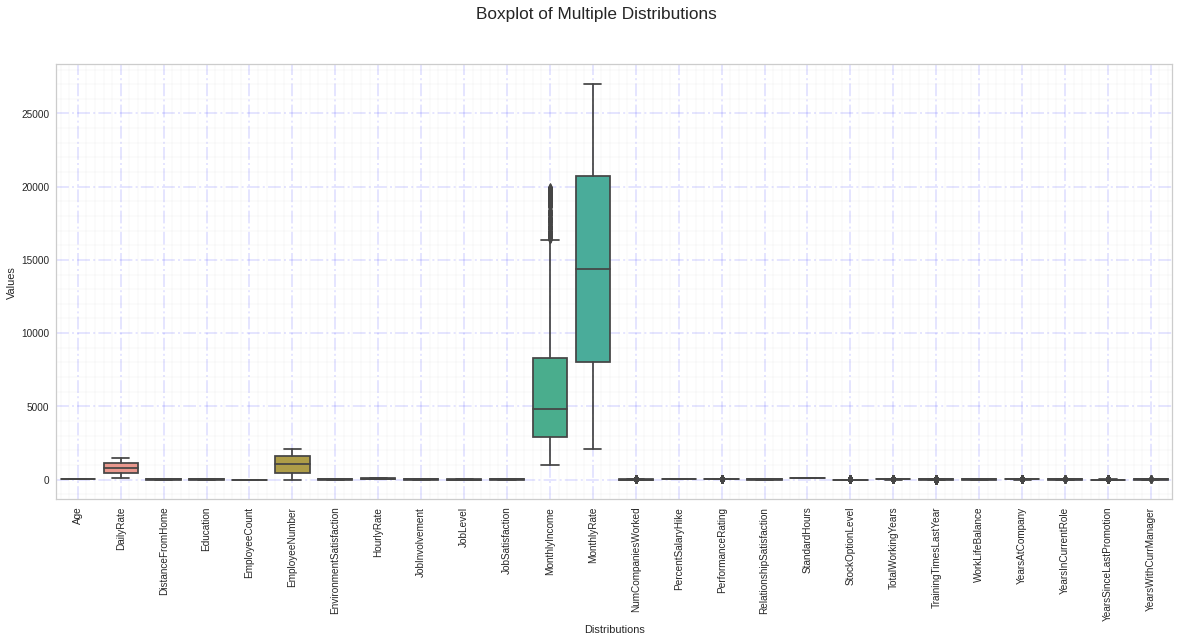

In [600]:
# Outlier Analysis
### Boxplot

fig = plt.figure(figsize = (20,8))
ax = plt.axes()

sns.boxplot(data=num_df)

plt.grid(color = 'blue', which = 'major', alpha = 0.1, linestyle = '-.', linewidth=2)
plt.minorticks_on()
plt.grid(color = 'grey', which = 'minor', alpha = 0.2, linestyle = '-', linewidth = 0.3)

ax.set_xlabel('Distributions')
ax.set_ylabel('Values')

plt.xticks(rotation=90)

fig.suptitle('Boxplot of Multiple Distributions', fontsize = 'xx-large')

plt.show()

Ah! with the boxplot we see outliers in the `MonthlyIncome` column. We will handle it later

#### Correlation Analysis

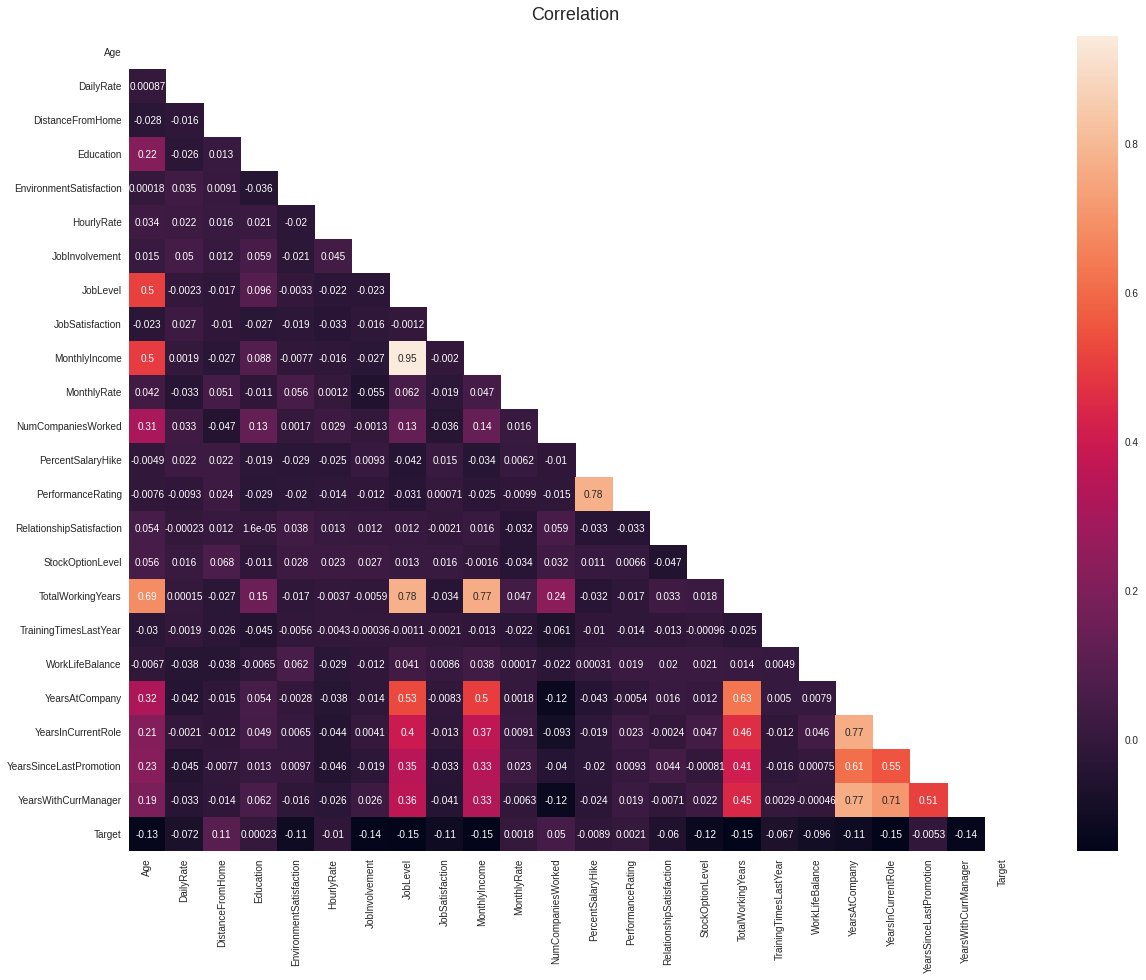

In [601]:
# Correlation Analysis
train_df_corr = train_df.copy()
train_df_corr['Target'] = train_df_corr['Attrition'].apply(lambda x: 0 if x == 'No' else 1)
train_df_corr = train_df_corr.drop(['Attrition', 'EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis=1)

plt.figure(figsize=(20, 15))

# Create mask for diagonal correlation plot
mask = np.triu(np.ones_like(train_df_corr.corr(), dtype=np.bool))

# Plot the heatmap
heatmap = sns.heatmap(train_df_corr.corr(), mask=mask, annot=True)
heatmap.set_title('Correlation', fontdict={'fontsize':18}, pad=16);

As shown above, "Monthly Rate", "Number of Companies Worked" and "Distance From Home" are positively correlated to Attrition; while the other are negatively correlated to Attrition.

* The higher the monthly income, the higher the job level of an employee.
* The higher the percent salary hike, the higher the performance rating.
* The higher the total working years, the higher the age, job level, monthly income and years at company.
* The higher the years at company, the higher the years in current role, years with current manager and year since lance promotion.

#### EDA Conclusions

Let's summarise the findings from this EDA:

* The dataset does not feature any missing or erroneous data values, and all features are of the correct data type.
* The strongest positive correlations with the target features are: Monthly Rate, Num Companies Worked, Distance From Home.
* The strongest negative correlations with the target features are: Total Working Years, Job Level, Years In Current Role, and Monthly Income.
* The dataset is imbalanced with the majoriy of observations describing Currently Active Employees.
* Several features (ie columns) are redundant for our analysis, namely: EmployeeCount, EmployeeNumber, StandardHours, and Over18.

Other observations include:

* People are tending to switch to a different jobs at the start of their careers, or at the earlier parts of it. Once they have settled with a family or have found stability in their jobs, they tend to stay long in the same organization- only going for vertical movements in the same organization.
* Salary and stock options have a great motivation on the employees and people tend to leave the organization much lesser. Higher pay and more stock options have seen more employees remain loyal to their company.
* Work life balance is a great motivation factor for the employees. However, people with a good work-life balance, tend to switch in search of better opportunities and a better standard of living.
* Departments where target meeting performance is very much crucial (for e.g. Sales) tend to have a greater chances of leaving the organization as compared to departments with more office perspective (For e.g. Research & Development)
* People with a good Job Satisfaction and Environment satisfaction are loyal to the organization- and this speaks loud for any Organization. However, people who are not much satisfied with their current project- tend to leave the organization far more.

### Data Preparation

#### Duplicate Rows Handling

In [602]:
train_df[train_df.duplicated(keep=False)]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


There aren't any duplicate values in it.

#### Missing Value Handling

In [603]:
train_df['n_missing'] = train_df.isnull().sum(axis=1)

In [604]:
train_df.sort_values('n_missing',ascending=False)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,n_missing
272,28,No,Travel_Rarely,1158,Research & Development,9,3,Medical,1,377,4,Male,94,3,1,Research Scientist,4,Married,2000,2613,1,Y,No,23,4,4,80,1,5,3,2,5,2,0,4,0
95,54,No,Travel_Rarely,1217,Research & Development,2,4,Technical Degree,1,126,1,Female,60,3,3,Research Director,3,Married,14000,24001,9,Y,No,12,3,1,80,1,16,5,1,4,3,0,3,0
657,29,No,Travel_Rarely,1086,Research & Development,7,1,Medical,1,912,1,Female,62,2,1,Laboratory Technician,4,Divorced,3000,6054,6,Y,No,14,3,3,80,3,8,5,3,4,3,0,3,0
1091,33,No,Travel_Rarely,575,Research & Development,25,3,Life Sciences,1,1545,4,Male,44,2,2,Manufacturing Director,2,Single,4000,24152,1,Y,No,13,3,4,80,0,5,2,3,5,3,0,2,0
1178,20,No,Travel_Rarely,1141,Sales,2,3,Medical,1,1657,3,Female,31,3,1,Sales Representative,3,Single,3000,13251,1,Y,No,19,3,1,80,0,2,3,3,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,30,No,Travel_Rarely,241,Research & Development,7,3,Medical,1,1609,2,Male,48,2,1,Research Scientist,2,Married,2000,5348,1,Y,No,12,3,2,80,1,6,3,2,6,4,1,1,0
837,40,No,Travel_Frequently,593,Research & Development,9,4,Medical,1,1166,2,Female,88,3,3,Research Director,3,Single,13000,13782,9,Y,No,17,3,3,80,0,20,3,2,18,7,2,13,0
1030,31,No,Travel_Rarely,326,Sales,8,2,Life Sciences,1,1453,1,Male,31,3,3,Sales Executive,4,Divorced,11000,8386,1,Y,No,18,3,1,80,1,13,5,3,13,7,9,9,0
798,33,Yes,Travel_Rarely,1017,Research & Development,25,3,Medical,1,1108,1,Male,55,2,1,Research Scientist,2,Single,2000,2993,4,Y,Yes,20,4,2,80,0,5,0,3,2,2,2,2,0


In [605]:
train_df.drop('n_missing', axis=1, inplace=True)

This dataset is clean; there aren't any missing values in it. But, missing value types are checked only if the value is NaN. However, to be sure we will check the values ​​in each column.

In [606]:
# show all value and value count from all column
for column in train_df.columns:
    print(f"============= {column} =================")
    display(train_df[column].value_counts())
    print()

============= Age =================


35    67
34    64
31    61
29    58
32    53
33    49
30    48
36    48
40    46
38    45
27    41
37    41
28    39
39    36
45    36
26    31
41    30
42    27
46    26
24    23
25    23
44    22
43    21
50    21
49    20
55    18
48    18
47    17
22    16
51    14
52    14
54    13
58    13
23    13
53    11
56    11
21    11
20    10
18     6
59     6
19     5
57     2
60     2
Name: Age, dtype: int64


============= Attrition =================


No     979
Yes    197
Name: Attrition, dtype: int64


============= BusinessTravel =================


Travel_Rarely        850
Travel_Frequently    208
Non-Travel           118
Name: BusinessTravel, dtype: int64


============= DailyRate =================


691     5
575     4
715     4
906     4
1469    4
       ..
911     1
905     1
902     1
898     1
103     1
Name: DailyRate, Length: 772, dtype: int64


============= Department =================


Research & Development    767
Sales                     362
Human Resources            47
Name: Department, dtype: int64


============= DistanceFromHome =================


1     165
2     163
9      75
7      73
10     67
3      66
8      65
4      56
5      49
6      47
16     25
18     24
11     23
24     22
15     21
20     21
25     21
26     21
12     18
19     18
28     17
21     17
13     16
22     16
23     16
29     16
17     15
14     14
27      9
Name: DistanceFromHome, dtype: int64


============= Education =================


3    467
4    312
2    218
1    143
5     36
Name: Education, dtype: int64


============= EducationField =================


Life Sciences       496
Medical             363
Marketing           126
Technical Degree    102
Other                66
Human Resources      23
Name: EducationField, dtype: int64


============= EmployeeCount =================


1    1176
Name: EmployeeCount, dtype: int64


============= EmployeeNumber =================


2046    1
653     1
622     1
623     1
624     1
       ..
1379    1
1380    1
1382    1
1383    1
2048    1
Name: EmployeeNumber, Length: 1176, dtype: int64


============= EnvironmentSatisfaction =================


3    366
4    354
1    232
2    224
Name: EnvironmentSatisfaction, dtype: int64


============= Gender =================


Male      711
Female    465
Name: Gender, dtype: int64


============= HourlyRate =================


48    27
54    23
79    23
57    23
66    23
      ..
50    11
34    11
53     9
68     9
38     7
Name: HourlyRate, Length: 71, dtype: int64


============= JobInvolvement =================


3    688
2    311
4    115
1     62
Name: JobInvolvement, dtype: int64


============= JobLevel =================


1    443
2    427
3    177
4     74
5     55
Name: JobLevel, dtype: int64


============= JobRole =================


Sales Executive              265
Research Scientist           231
Laboratory Technician        215
Manufacturing Director       118
Healthcare Representative    100
Manager                       74
Sales Representative          66
Research Director             65
Human Resources               42
Name: JobRole, dtype: int64


============= JobSatisfaction =================


4    372
3    353
1    228
2    223
Name: JobSatisfaction, dtype: int64


============= MaritalStatus =================


Married     530
Single      378
Divorced    268
Name: MaritalStatus, dtype: int64


============= MonthlyIncome =================


3000     191
2000     172
5000     164
4000     149
6000      96
7000      63
10000     56
8000      42
9000      35
11000     34
19000     28
17000     22
13000     21
20000     19
14000     19
18000     17
1000      16
12000     15
16000     10
15000      7
Name: MonthlyIncome, dtype: int64


============= MonthlyRate =================


4223     3
9129     2
3339     2
4156     2
4658     2
        ..
19757    1
3372     1
23848    1
23844    1
12288    1
Name: MonthlyRate, Length: 1144, dtype: int64


============= NumCompaniesWorked =================


1    429
0    160
3    121
4    114
2    114
7     56
6     51
5     50
9     42
8     39
Name: NumCompaniesWorked, dtype: int64


============= Over18 =================


Y    1176
Name: Over18, dtype: int64


============= OverTime =================


No     850
Yes    326
Name: OverTime, dtype: int64


============= PercentSalaryHike =================


11    168
13    166
14    160
12    156
15     85
18     69
17     66
16     61
19     56
22     49
20     47
21     41
23     22
25     15
24     15
Name: PercentSalaryHike, dtype: int64


============= PerformanceRating =================


3    987
4    189
Name: PerformanceRating, dtype: int64


============= RelationshipSatisfaction =================


3    374
4    344
2    239
1    219
Name: RelationshipSatisfaction, dtype: int64


============= StandardHours =================


80    1176
Name: StandardHours, dtype: int64


============= StockOptionLevel =================


0    519
1    468
2    123
3     66
Name: StockOptionLevel, dtype: int64


============= TotalWorkingYears =================


10    159
6      97
8      85
5      80
9      77
7      70
1      69
4      49
12     35
11     33
3      33
2      29
15     29
16     28
13     27
14     25
21     25
20     25
17     22
18     21
19     20
22     16
23     16
24     15
25     13
28     11
26     10
29      8
0       7
27      7
31      6
32      6
33      5
30      4
34      4
36      3
37      3
40      2
38      1
35      1
Name: TotalWorkingYears, dtype: int64


============= TrainingTimesLastYear =================


2    437
3    393
4     96
5     92
1     58
6     53
0     47
Name: TrainingTimesLastYear, dtype: int64


============= WorkLifeBalance =================


3    713
2    271
4    125
1     67
Name: WorkLifeBalance, dtype: int64


============= YearsAtCompany =================


5     163
1     144
2     106
3      95
10     95
4      89
7      69
9      68
8      65
6      58
0      33
11     25
13     21
20     19
15     17
22     13
14     13
18     11
21     11
16     10
19     10
12      7
17      6
24      5
25      4
26      3
33      3
23      2
36      2
29      2
32      1
34      1
37      1
31      1
30      1
27      1
40      1
Name: YearsAtCompany, dtype: int64


============= YearsInCurrentRole =================


2     296
0     201
7     181
3     104
4      81
8      71
1      47
9      47
5      32
6      29
10     25
11     18
13     12
12      8
14      7
15      6
16      6
17      4
18      1
Name: YearsInCurrentRole, dtype: int64


============= YearsSinceLastPromotion =================


0     473
1     284
2     132
7      56
4      52
3      40
5      36
6      27
11     17
8      14
9      10
15      9
14      8
13      7
12      7
10      4
Name: YearsSinceLastPromotion, dtype: int64


============= YearsWithCurrManager =================


2     276
0     221
7     162
3     113
8      87
4      79
1      66
9      48
6      24
5      22
10     21
12     15
11     14
13     12
14      5
17      5
15      4
16      2
Name: YearsWithCurrManager, dtype: int64

Luckily for us, there is no missing data!

#### Encoding

In [607]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Create a label encoder object
le = LabelEncoder()

In [608]:
# label encode train data
le_count = 0
for col in train_df.columns[1:]:
    if train_df[col].dtype == 'object':
        if len(list(train_df[col].unique())) <= 2:
            le.fit(train_df[col])
            train_df[col] = le.transform(train_df[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

4 columns were label encoded.


In [609]:
# label encode test data
le_count = 0
for col in test_df.columns[1:]:
    if test_df[col].dtype == 'object':
        if len(list(test_df[col].unique())) <= 2:
            le.fit(test_df[col])
            test_df[col] = le.transform(test_df[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

4 columns were label encoded.


In [610]:
# convert rest of categorical variable into dummy
train_df = pd.get_dummies(train_df, drop_first=True)

In [611]:
# convert rest of categorical variable into dummy
test_df = pd.get_dummies(test_df, drop_first=True)

In [612]:
train_df.shape

(1176, 49)

In [613]:
test_df.shape

(294, 49)

In [614]:
train_df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
272,28,0,1158,9,3,1,377,4,1,94,3,1,4,2000,2613,1,0,0,23,4,4,80,1,5,3,2,5,2,0,4,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
909,19,0,265,25,3,1,1269,2,0,57,4,1,4,3000,21221,1,0,1,12,3,4,80,0,1,2,3,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
975,55,1,267,13,4,1,1372,1,1,85,4,4,3,14000,9277,6,0,1,17,3,3,80,0,24,2,2,19,7,3,8,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
1383,36,0,1351,9,4,1,1949,1,1,66,4,1,2,3000,9238,1,0,0,22,4,2,80,0,5,3,3,5,4,0,2,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
191,27,0,894,9,3,1,260,4,0,99,3,1,2,2000,11781,1,0,0,16,3,4,80,0,7,2,2,7,7,0,3,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


#### Feature Scaling

In [615]:
train_df.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.00000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,36.464286,0.167517,791.761905,9.108844,2.897959,1.0,1025.671769,2.715986,0.604592,65.627551,2.727891,2.039966,2.738946,6400.510204,14438.312925,2.647959,0.0,0.277211,15.235544,3.160714,2.716837,80.0,0.775510,11.008503,2.783163,2.761905,6.92602,4.198129,2.092687,4.027211,0.176871,0.722789,0.652211,0.307823,0.421769,0.107143,0.308673,0.056122,0.086735,0.035714,0.182823,0.062925,0.100340,0.055272,0.196429,0.225340,0.056122,0.450680,0.321429
std,9.031694,0.373596,400.486059,7.944599,1.024697,0.0,610.567646,1.095888,0.489146,20.332279,0.706761,1.095104,1.101974,4672.450694,7136.866260,2.489169,0.0,0.447812,3.674843,0.367423,1.077707,0.0,0.848897,7.633962,1.297364,0.713000,6.05356,3.619902,3.117131,3.573559,0.381722,0.447812,0.476471,0.461789,0.494052,0.309426,0.462143,0.230256,0.281566,0.185656,0.386686,0.242932,0.300581,0.228608,0.397465,0.417984,0.230256,0.497773,0.467224
min,18.000000,0.000000,103.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,30.000000,1.000000,1.000000,1.000000,1000.000000,2094.000000,0.000000,0.0,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,460.500000,2.000000,2.000000,1.0,470.500000,2.000000,0.000000,48.000000,2.000000,1.000000,2.000000,3000.000000,8057.500000,1.000000,0.0,0.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.00000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,35.000000,0.000000,783.000000,7.000000,3.000000,1.0,1031.000000,3.000000,1.000000,66.000000,3.000000,2.000000,3.000000,5000.000000,14379.500000,1.000000,0.0,0.000000,14.000000,3.000000,3.000000,80.0,1.000000,9.000000,3.000000,3.000000,5.00000,3.000000,1.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,42.000000,0.000000,1144.000000,13.000000,4.000000,1.0,1578.500000,4.000000,1.000000,83.000000,3.000000,3.000000,4.000000,8000.000000,20741.750000,4.000000,0.0,1.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.00000,7.000000,2.0

In [616]:
from sklearn.preprocessing import StandardScaler
headers = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike', 'NumCompaniesWorked', 'TotalWorkingYears', 
          'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
scaler = StandardScaler()
for col in headers:
    train_df[col] = train_df[col].astype(float)
    train_df[[col]] = scaler.fit_transform(train_df[[col]])
train_df.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
count,1.176000e+03,1176.000000,1.176000e+03,1.176000e+03,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1.176000e+03,1176.000000,1176.000000,1176.000000,1.176000e+03,1.176000e+03,1.176000e+03,1176.0,1176.000000,1.176000e+03,1176.000000,1176.000000,1176.0,1176.000000,1.176000e+03,1.176000e+03,1176.000000,1.176000e+03,1.176000e+03,1.176000e+03,1.176000e+03,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,-2.008031e-16,0.167517,-1.445367e-16,-2.638078e-17,2.897959,1.0,1025.671769,2.715986,0.604592,8.260588e-18,2.727891,2.039966,2.738946,-2.360168e-18,-5.817814e-17,-4.871387e-17,0.0,0.277211,-7.816876e-17,3.160714,2.716837,80.0,0.775510,8.687778e-17,2.494698e-17,2.761905,-2.454103e-16,-1.797740e-16,5.249014e-17,6.514064e-18,0.176871,0.722789,0.652211,0.307823,0.421769,0.107143,0.308673,0.056122,0.086735,0.035714,0.182823,0.062925,0.100340,0.055272,0.196429,0.225340,0.056122,0.450680,0.321429
std,1.000425e+00,0.373596,1.000425e+00,1.000425e+00,1.024697,0.0,610.567646,1.095888,0.489146,1.000425e+00,0.706761,1.095104,1.101974,1.000425e+00,1.000425e+00,1.000425e+00,0.0,0.447812,1.000425e+00,0.367423,1.077707,0.0,0.848897,1.000425e+00,1.000425e+00,0.713000,1.000425e+00,1.000425e+00,1.000425e+00,1.000425e+00,0.381722,0.447812,0.476471,0.461789,0.494052,0.309426,0.462143,0.230256,0.281566,0.185656,0.386686,0.242932,0.300581,0.228608,0.397465,0.417984,0.230256,0.497773,0.467224
min,-2.045258e+00,0.000000,-1.720547e+00,-1.021108e+00,1.000000,1.0,1.000000,1.000000,0.000000,-1.753011e+00,1.000000,1.000000,1.000000,-1.156311e+00,-1.730390e+00,-1.064245e+00,0.0,0.000000,-1.153069e+00,3.000000,1.000000,80.0,0.000000,-1.442657e+00,-2.146157e+00,1.000000,-1.144610e+00,-1.160229e+00,-6.716359e-01,-1.127426e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.160380e-01,0.000000,-8.275016e-01,-8.951827e-01,2.000000,1.0,470.500000,2.000000,0.000000,-8.673425e-01,2.000000,1.000000,2.000000,-7.280884e-01,-8.944441e-01,-6.623336e-01,0.0,0.000000,-8.808324e-01,3.000000,2.000000,80.0,0.000000,-6.563609e-01,-6.039139e-01,2.000000,-6.488233e-01,-6.074928e-01,-6.716359e-01,-5.675220e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.621965e-01,0.000000,-2.188748e-02,-2.655566e-01,3.000000,1.0,1031.000000,3.000000,1.000000,1.832591e-02,3.000000,2.000000,3.000000,-2.998653e-01,-8.244227e-03,-6.623336e-01,0.0,0.000000,-3.363599e-01,3.000000,3.000000,80.0,1.000000,-2.632130e-01,1.672074e-01,3.000000,-3.182986e-01,-3.311247e-01,-3.506916e-01,-2.875699e-01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [617]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 5))
# train_col = list(train_df.columns)
# train_col.remove('Attrition')
# for col in train_col:
#     train_df[col] = train_df[col].astype(float)
#     train_df[[col]] = scaler.fit_transform(train_df[[col]])
# train_df['Attrition'] = pd.to_numeric(train_df['Attrition'], downcast='float')
# train_df.head()

In [618]:
from sklearn.preprocessing import StandardScaler
headers = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike', 'NumCompaniesWorked', 'TotalWorkingYears', 
          'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
scaler = StandardScaler()
for col in headers:
    test_df[col] = test_df[col].astype(float)
    test_df[[col]] = scaler.fit_transform(test_df[[col]])
test_df.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
count,2.940000e+02,294.000000,2.940000e+02,2.940000e+02,294.000000,294.0,294.000000,294.000000,294.000000,2.940000e+02,294.000000,294.000000,294.000000,2.940000e+02,2.940000e+02,2.940000e+02,294.0,294.000000,2.940000e+02,294.000000,294.000000,294.0,294.000000,2.940000e+02,2.940000e+02,294.000000,2.940000e+02,2.940000e+02,2.940000e+02,2.940000e+02,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,2.644332e-16,0.136054,-8.760944e-17,8.793986e-17,2.972789,1.0,1021.639456,2.744898,0.581633,1.019593e-16,2.738095,2.159864,2.687075,-3.021015e-17,1.263398e-16,-2.643388e-17,0.0,0.306122,2.405483e-16,3.125850,2.693878,80.0,0.867347,-9.308503e-17,1.129104e-16,2.758503,3.927320e-17,-1.200853e-16,-2.530100e-17,-1.004487e-16,0.234694,0.656463,0.659864,0.285714,0.374150,0.112245,0.343537,0.054422,0.102041,0.034014,0.149660,0.095238,0.091837,0.051020,0.207483,0.207483,0.057823,0.486395,0.312925
std,1.001705e+00,0.343431,1.001705e+00,1.001705e+00,1.021580,0.0,567.549952,1.083332,0.494132,1.001705e+00,0.731620,1.149991,1.107238,1.001705e+00,1.001705e+00,1.001705e+00,0.0,0.461667,1.001705e+00,0.332246,1.096767,0.0,0.862227,1.001705e+00,1.001705e+00,0.680929,1.001705e+00,1.001705e+00,1.001705e+00,1.001705e+00,0.424530,0.475699,0.474562,0.452524,0.484728,0.316206,0.475699,0.227235,0.303218,0.181573,0.357346,0.294044,0.289288,0.220415,0.406196,0.406196,0.233807,0.500667,0.464475
min,-2.228991e+00,0.000000,-1.801727e+00,-9.781977e-01,1.000000,1.0,12.000000,1.000000,0.000000,-1.821433e+00,1.000000,1.000000,1.000000,-1.108646e+00,-1.665158e+00,-1.138304e+00,0.0,0.000000,-1.141076e+00,3.000000,1.000000,80.0,0.000000,-1.498073e+00,-2.283260e+00,1.000000,-1.146487e+00,-1.198264e+00,-7.157967e-01,-1.280217e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.259558e-01,0.000000,-8.419449e-01,-8.634828e-01,2.000000,1.0,558.500000,2.000000,0.000000,-8.354244e-01,2.000000,1.000000,2.000000,-7.823140e-01,-8.334884e-01,-7.422554e-01,0.0,0.000000,-8.631337e-01,3.000000,2.000000,80.0,0.000000,-7.710852e-01,-6.887745e-01,2.000000,-6.776873e-01,-6.478117e-01,-7.157967e-01,-7.120906e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-8.179784e-02,0.000000,1.032955e-01,-2.899086e-01,3.000000,1.0,1001.500000,3.000000,1.000000,2.683017e-03,3.000000,2.000000,3.000000,-3.086257e-01,-6.294107e-02,-3.462062e-01,0.0,0.000000,-3.072491e-01,3.000000,3.000000,80.0,1.000000,-2.864266e-01,1.084684e-01,3.000000,-2.088871e-01,-3.725854e-01,-4.370626e-01,-4.280273e-01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.

In [619]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 5))
# test_col = list(test_df.columns)
# test_col.remove('Attrition')
# for col in test_col:
#     test_df[col] = test_df[col].astype(float)
#     test_df[[col]] = scaler.fit_transform(test_df[[col]])
# test_df['Attrition'] = pd.to_numeric(test_df['Attrition'], downcast='float')
# test_df.head()

#### Drop Un-Used Features

In [620]:
train_df.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis=1, inplace=True)

In [621]:
test_df.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis=1, inplace=True)

#### Outliers After Standardization

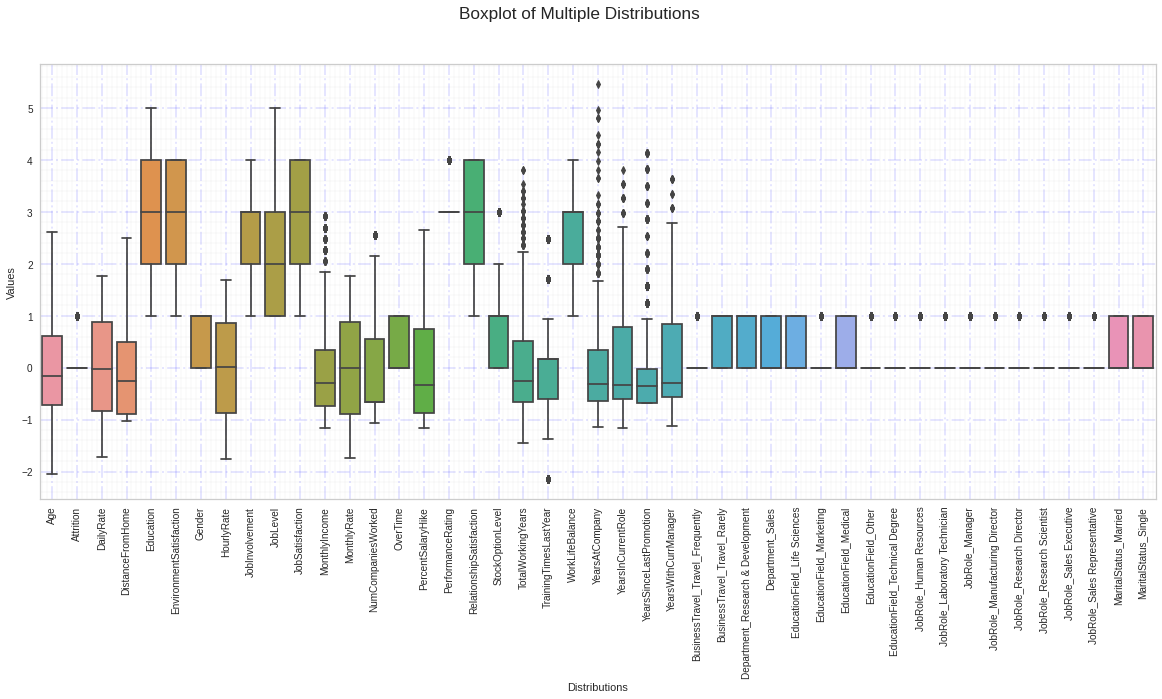

In [622]:
### Boxplot

fig = plt.figure(figsize = (20,8))
ax = plt.axes()

sns.boxplot(data=train_df)

plt.grid(color = 'blue', which = 'major', alpha = 0.1, linestyle = '-.', linewidth=2)
plt.minorticks_on()
plt.grid(color = 'grey', which = 'minor', alpha = 0.2, linestyle = '-', linewidth = 0.3)

ax.set_xlabel('Distributions')
ax.set_ylabel('Values')

plt.xticks(rotation=90)

fig.suptitle('Boxplot of Multiple Distributions', fontsize = 'xx-large')

plt.show()

### Modeling & Evaluation

#### Feature Selection

In [623]:
X_train = train_df.drop('Attrition', axis=1)
y_train = train_df['Attrition']

In [624]:
X_test = test_df.drop('Attrition', axis=1)
y_test = test_df['Attrition']

#### Logistic Regression

In [625]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [626]:
y_pred = lr.predict(X_test)

##### Confustion Matrix

The Confusion matrix provides us with a much more detailed representation of the accuracy score and of what's going on with our labels - we know exactly which/how labels were correctly and incorrectly predicted

In [627]:
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

In [628]:
print(cm)
print(report)

[[239  15]
 [ 20  20]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       254
           1       0.57      0.50      0.53        40

    accuracy                           0.88       294
   macro avg       0.75      0.72      0.73       294
weighted avg       0.87      0.88      0.88       294



##### AUC Score

In [629]:
lr.fit(X_train, y_train) # fit optimised model to the training data
probs = lr.predict_proba(X_test) # predict probabilities
probs = probs[:, 1] # we will only keep probabilities associated with the employee leaving
logit_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
print('AUC score: %.3f' % logit_roc_auc)

AUC score: 0.838


#### Random Forest

In [674]:
rf = RandomForestClassifier(random_state=41)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=41, verbose=0,
                       warm_start=False)

In [675]:
y_pred = rf.predict(X_test)

##### Confustion Matrix

In [676]:
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

In [677]:
print(cm)
print(report)

[[253   1]
 [ 29  11]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       254
           1       0.92      0.28      0.42        40

    accuracy                           0.90       294
   macro avg       0.91      0.64      0.68       294
weighted avg       0.90      0.90      0.87       294



##### AUC Score

In [678]:
rf.fit(X_train, y_train) # fit optimised model to the training data
probs = rf.predict_proba(X_test) # predict probabilities
probs = probs[:, 1] # we will only keep probabilities associated with the employee leaving
rf_opt_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
print('AUC score: %.3f' % rf_opt_roc_auc)

AUC score: 0.845


##### Important Features

Random Forest allows us to know which features are of the most importance in predicting the target feature ("attrition" in this project). Below, we plot features by their importance.

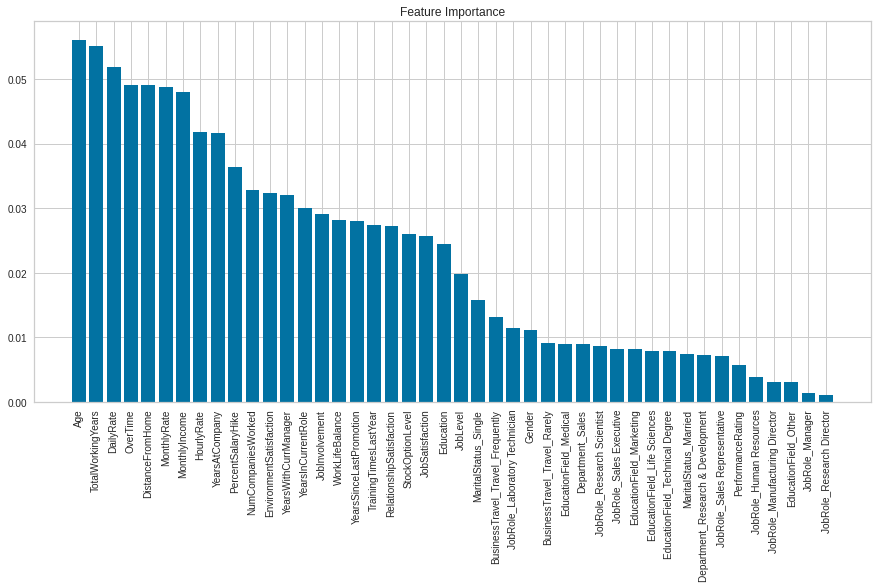

In [679]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] 
names = [X_train.columns[i] for i in indices] 
plt.figure(figsize=(15, 7)) 
plt.title("Feature Importance") 
plt.bar(range(X_train.shape[1]), importances[indices]) 
plt.xticks(range(X_train.shape[1]), names, rotation=90) 
plt.show() # Show plot

#### ROC Graph

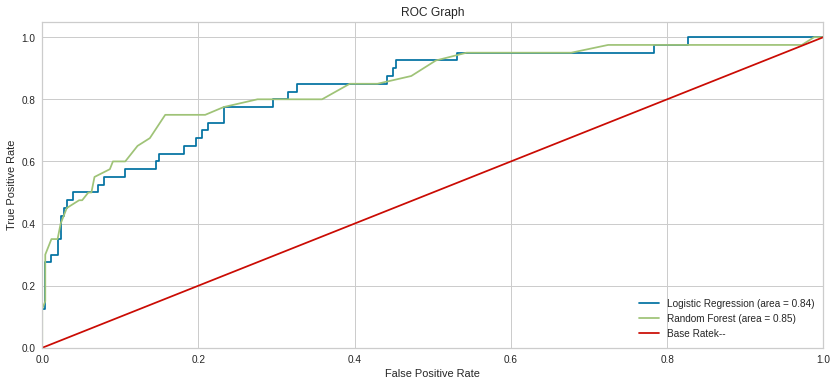

In [680]:
# Create ROC Graph
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_opt_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. The green line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

#### SVM

In [681]:
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [682]:
y_pred = svc.predict(X_test)

Confusion Matrix

In [683]:
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

In [684]:
print(cm)
print(report)

[[253   1]
 [ 30  10]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       254
           1       0.91      0.25      0.39        40

    accuracy                           0.89       294
   macro avg       0.90      0.62      0.67       294
weighted avg       0.90      0.89      0.87       294



### Conclusion

About Modeling:
* Logistics Regression Model will be better when using data normalization, accuracy will increase immediately. However, when using class weights, the accuracy is not as good as normalization.
* The Random Forest model can handle data without normalizing numerical features, better than Logistic Regression. Surprisingly, when using class weights, the Random Forest model's accuracy decreases.
* This proves that normalized data is better for modeling and random forest is stronger against non-normalized data.
* Accuracy is quite good and usable.

Main Reasons why Employees leave the Organization:
* Daily Rate: As expected, Earnings is a big factor why employees leave the organization in search of a better salary.
* Age: This is also to be expected, as people wishing to retire will leave the organization.
* Total Working Years: Very naturally, very long-standing employees are less likely to leave. Employees with between 6-10 years of experience should be identified as potentially at higher risk of leaving.

Knowing the most likely reasons why employees leave the organization, can help the organization take action and reduce the level of friction within the organization.

Strategic Retention:
* Daily Rate: people on higher wages are less likely to leave the company. Hence, efforts should be made to gather information on industry benchmarks in the current local market to determine if the company is providing competitive wages.
* Age: Employees in relatively young age bracket 25-33 are more likely to leave. Hence, efforts should be made to clearly articulate the long-term vision of the company and young employees fit in that vision, as well as provide incentives in the form of clear paths to promotion for instance.
* DistanceFromHome: Employees who live further from home are more likely to leave the company. Hence, efforts should be made to provide support in the form of company transportation for clusters of employees leaving the same area, or in the form of Transportation Allowance.